Let's try to clean up the dataset as best as we can, and create something we can do some model prototyping with! For prototyping we'll want something that's small, and ideally fits within Kaggle's 20GB limit so we can upload it as a dataset for others to easily work with. (If you're just looking for the dataset created with this notebook, you can [find it here](https://www.kaggle.com/jhoward/rsna-hemorrhage-png).)

Here are the issues that we will address.

1. Fix images with incorrect RescaleIntercept
1. Remove some images if they have little useful information (e.g. they don't actually contain brain tissue)
1. Resample this dataset to 2/1 split of with/without haemorrhage, so we have a smaller dataset for quick prototyping
1. Crop the images to just contain the brain, and save the size of the crop in case it's important
1. Do histogram rescaling and then save 16 bit PNG 256x256 px images

We'll be using the fastai.medical.imaging library here - for more information about this see the notebook [Some DICOM gotchas to be aware of](https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai). We'll also use the same basic setup that's in the notebook.

In [1]:
!pip install torch torchvision feather-format kornia pyarrow --upgrade   > /dev/null
!pip install git+https://github.com/fastai/fastai_dev                    > /dev/null

ERROR: allennlp 0.9.0 requires flaky, which is not installed.
ERROR: allennlp 0.9.0 requires responses>=0.7, which is not installed.
  Running command git clone -q https://github.com/fastai/fastai_dev /tmp/pip-req-build-gi96bl0b


In [2]:
from fastai2.basics           import *
from fastai2.vision.all       import *
from fastai2.medical.imaging  import *

np.set_printoptions(linewidth=120)
matplotlib.rcParams['image.cmap'] = 'bone'
torch.set_num_threads(1)
set_num_threads(1)

path = Path('../input/rsna-intracranial-hemorrhage-detection/')
path_trn = path/'stage_1_train_images'
path_tst = path/'stage_1_test_images'
path_dest = Path()
path_dest.mkdir(exist_ok=True)

path_inp = Path('../input')

In [3]:
path_df = path_inp/'creating-a-metadata-dataframe'
df_lbls = pd.read_feather(path_df/'labels.fth')
df_tst = pd.read_feather(path_df/'df_tst.fth')
df_trn = pd.read_feather(path_df/'df_trn.fth').dropna(subset=['img_pct_window'])
comb = df_trn.join(df_lbls.set_index('ID'), 'SOPInstanceUID')

# Fix incorrect RescaleIntercept

In an earlier notebook ("[Some DICOM gotchas to be aware of](https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai)") we saw that there are some images which seem to have incorrect values for RescaleIntercept. In addition, in [this comment](https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai/comments#646349) Malcolm McLean pointed out that the values in these images seem wrong. Let's see if we can figure out what's happening, and fix them! Here are the data subsets we created in the previous notebook:

In [4]:
repr_flds = ['BitsStored','PixelRepresentation']
df1 = comb.query('(BitsStored==12) & (PixelRepresentation==0)')
df2 = comb.query('(BitsStored==12) & (PixelRepresentation==1)')
df3 = comb.query('BitsStored==16')
dfs = L(df1,df2,df3)

The problematic images are those in `df1`, which don't have the expected `RescaleIntercept` of `-1024` or similar. We'll grab that subset, and have a look at a few of them

In [5]:
def df2dcm(df): return L(Path(o).dcmread() for o in df.fname.values)

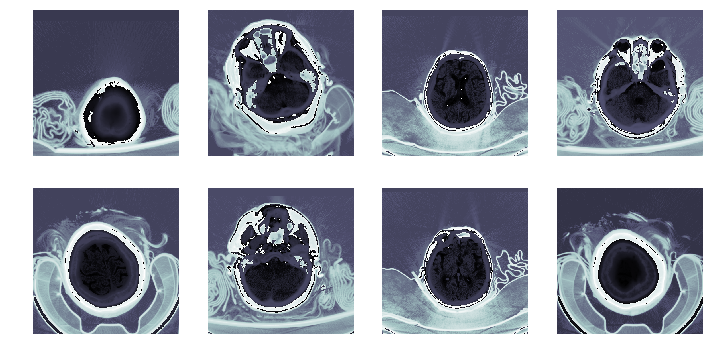

In [6]:
df_iffy = df1[df1.RescaleIntercept>-100]
dcms = df2dcm(df_iffy)

_,axs = subplots(2,4, imsize=3)
for i,ax in enumerate(axs.flat): dcms[i].show(ax=ax)

Oh dear, they don't look good at all! Let's pick one for further analysis, and start with looking at the histogram of pixel values:

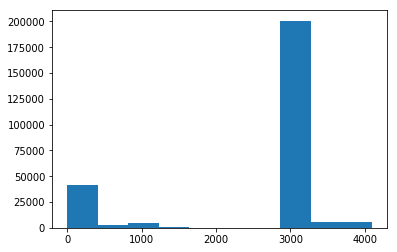

In [7]:
dcm = dcms[2]
d = dcm.pixel_array
plt.hist(d.flatten());

Normally the mode for unsigned data images is zero, since they are the background pixels, as you see here:

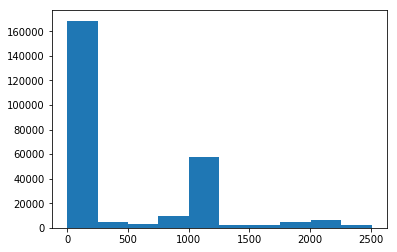

In [8]:
d1 = df2dcm(df1.iloc[[0]])[0].pixel_array
plt.hist(d1.flatten());

Instead, our mode is:

In [9]:
scipy.stats.mode(d.flatten()).mode[0]

3096

My guess is that what happened in the "iffy" images is that they were actually signed data, but were treated as unsigned. If that's the case, the a value of `-1000` or `-1024` (the usual values for background pixels in signed data images) will have wrapped around to `4096-1000=3096`. So we'll need to shift everything up by `1000`, then move the values larger than `2048` back to where they should have been.

In [10]:
d += 1000

px_mode = scipy.stats.mode(d.flatten()).mode[0]
d[d>=px_mode] = d[d>=px_mode] - px_mode
dcm.PixelData = d.tobytes()
dcm.RescaleIntercept = -1000

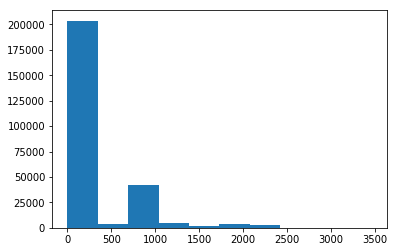

In [11]:
plt.hist(dcm.pixel_array.flatten());

Let's see if that helped.

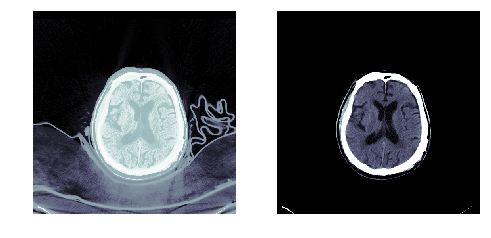

In [12]:
_,axs = subplots(1,2)
dcm.show(ax=axs[0]);   dcm.show(dicom_windows.brain, ax=axs[1])

That looks pretty much perfect! We'll put that into a function that we can use to fix all our problematic images.

In [13]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

Let's see if they all clean up so nicely.

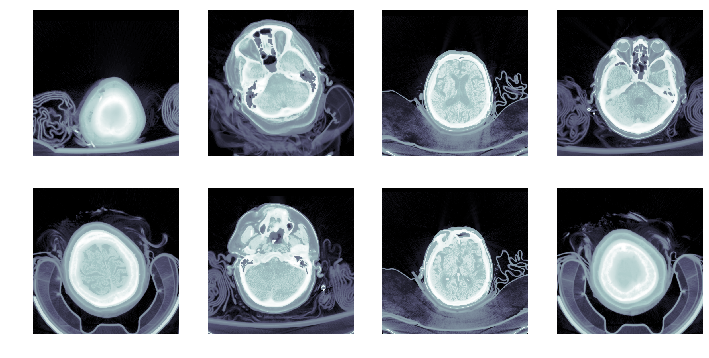

In [14]:
dcms = df2dcm(df_iffy)
dcms.map(fix_pxrepr)

_,axs = subplots(2,4, imsize=3)
for i,ax in enumerate(axs.flat): dcms[i].show(ax=ax)

# Remove useless images

Our goal here is to create a small, fast, convenient dataset for rapid prototyping. So let's get rid of images that don't provide much useful information, such as those with very little actual brain tissue in them. Brain tissue is in the region `(0,80)`. Let's find out how many pixels in this region are in each image. When we created the metadata data frame, we got a `img_pct_window` column included which has the % of pixels in the brain window.

In [15]:
df_iffy.img_pct_window[:10].values

array([0.03567886, 0.14665604, 0.1501503 , 0.18796158, 0.09502792, 0.17225647, 0.15142441, 0.02574921, 0.14790726,
       0.15719604])

We see that the first image contains nearly no brain tissue. It seems unlikely that images like this will have noticable haemorrhages. Let's test this hypothesis.

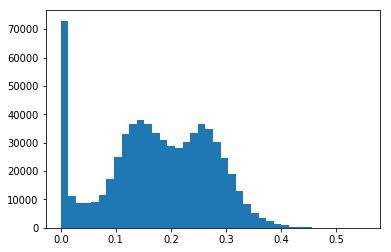

In [16]:
plt.hist(comb.img_pct_window,40);

There are a *lot* of images with nearly no brain tissue in them - presumably they're the slices above and below the brain. Let's see if they have any labels:

In [17]:
comb = comb.assign(pct_cut = pd.cut(comb.img_pct_window, [0,0.02,0.05,0.1,0.2,0.3,1]))
comb.pivot_table(values='any', index='pct_cut', aggfunc=['sum','count']).T

,pct_cut,"(0.0, 0.02]","(0.02, 0.05]","(0.05, 0.1]","(0.1, 0.2]","(0.2, 0.3]","(0.3, 1.0]"
sum,any,61,696,3312,21137,55437,16459
count,any,70673,19706,45886,241859,226345,61798


We can see that, as expected, the images with little brain tissue (<2% of pixels) have almost no labels. So let's remove them. (Interestingly, we can also see a strong relationship between these two variables.)

In [18]:
comb.drop(comb.query('img_pct_window<0.02').index, inplace=True)

# Resample to 2/3 split

We will keep every row with a label:

In [19]:
df_lbl = comb.query('any==True')
n_lbl = len(df_lbl)
n_lbl

97041

...and we'll keep half that number of images without a label, which should keep the resultant size under Kaggle's 20GB dataset limit:

In [20]:
df_nonlbl = comb.query('any==False').sample(n_lbl//2)
len(df_nonlbl)

48520

Let's put them altogether and see how many we have.

In [21]:
comb = pd.concat([df_lbl,df_nonlbl])
len(comb)

145561

# Crop to just brain area

To create a smaller and faster dataset, we'll need smaller images. So let's make sure they contain the important information, by cropping out the non-brain area. To do so, we start with an image like this:

In [22]:
dcm = Path(dcms[3].filename).dcmread()
fix_pxrepr(dcm)

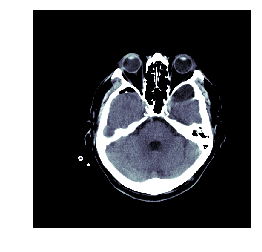

In [23]:
px = dcm.windowed(*dicom_windows.brain)
show_image(px);

...then blur it, to remove the small and thin areas:

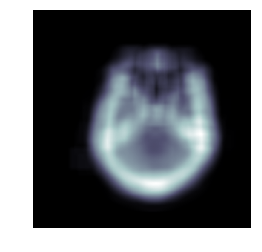

In [24]:
blurred = gauss_blur2d(px, 100)
show_image(blurred);

...and just select the areas that are bright in this picture:

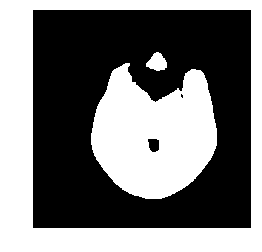

In [25]:
show_image(blurred>0.3);

We can use `fastai`'s `mask_from_blur` method to do this for us. We'll overlay the results on a few images to see if it looks OK:

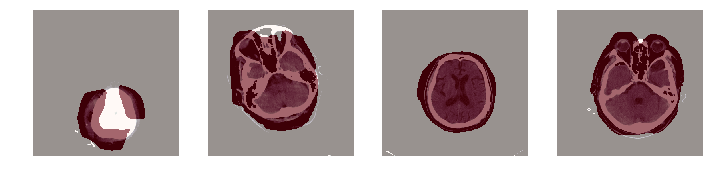

In [26]:
_,axs = subplots(1,4, imsize=3)
for i,ax in enumerate(axs.flat):
    dcms[i].show(dicom_windows.brain, ax=ax)
    show_image(dcms[i].mask_from_blur(dicom_windows.brain), cmap=plt.cm.Reds, alpha=0.6, ax=ax)

It's not perfect, but it'll do for our prototyping purposes. Now we need something that finds the extreme pixels. That turns out to be fairly simple:

In [27]:
def pad_square(x):
    r,c = x.shape
    d = (c-r)/2
    pl,pr,pt,pb = 0,0,0,0
    if d>0: pt,pd = int(math.floor( d)),int(math.ceil( d))        
    else:   pl,pr = int(math.floor(-d)),int(math.ceil(-d))
    return np.pad(x, ((pt,pb),(pl,pr)), 'minimum')

def crop_mask(x):
    mask = x.mask_from_blur(dicom_windows.brain)
    bb = mask2bbox(mask)
    if bb is None: return
    lo,hi = bb
    cropped = x.pixel_array[lo[0]:hi[0],lo[1]:hi[1]]
    x.pixel_array = pad_square(cropped)

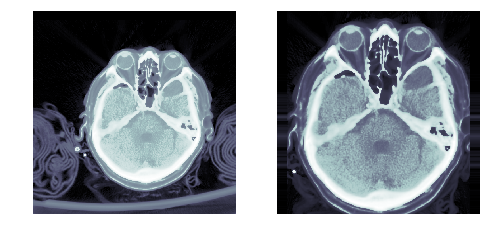

In [28]:
_,axs = subplots(1,2)
dcm.show(ax=axs[0])
crop_mask(dcm)
dcm.show(ax=axs[1]);

# Save 16 bit PNG images

We will save our smaller cropped files as 16 bit PNGs. A lot of folks aren't aware that PNG supports 16 bit files - it's a really convenient format since you can open it with standard libraries. And all our metadata is already in data frames, so there's no need to store it inside the image files too, like DICOM does.

When we save the files, we'll first use frequency-binned histogram normalization, so that the 16 bit files will include a nice distribution of pixels, without needing any further processing. See this notebook to learn how this works: "[DON'T see like a radiologist!](https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai)".

In [29]:
htypes = 'any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural'

def get_samples(df):
    recs = [df.query(f'{c}==1').sample() for c in htypes]
    recs.append(df.query('any==0').sample())
    return pd.concat(recs).fname.values

sample_fns = concat(*dfs.map(get_samples))
sample_dcms = tuple(Path(o).dcmread().scaled_px for o in sample_fns)
samples = torch.stack(sample_dcms)
bins = samples.freqhist_bins()

We'll also save those bins, since we'll need them for processing the full dataset when we use it later, and for the test set when it's time to submit.

In [30]:
(path_dest/'bins.pkl').save(bins)

Here's the steps to read a fix a single file, ensuring it's the standard 512x512 size (nearly all are that size already, but we need them to be consistent in later processing). Also, if there are any broken files, we'll skip them, by raising fastai's `SkipItemException` (which means "don't use this file in the `DataLoader`).

In [31]:
def dcm_tfm(fn): 
    fn = Path(fn)
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    return x.scaled_px

If we're not careful, processing 300GB of input data could take a *really* long time! To make it super fast, we'll do it in 3 steps:

- Create a multiprocess `DataLoader` that reads, fixes, and rescales the DICOMs, returning batches of size `bs`
- Loop through each batch, moving it to the GPU, and then using fastai's GPU-optimized masking, cropping, and resizing functions on the whole batch at once
- For each batch, save each image in it in parallel, using fastai's `parallel` function.

This is the first time that I've shown how to combine parallel and GPU processing for preprocessing and saving medical images (and might be the first time it's been shown anywhere, at least using something this flexible and concise!)

Let's start by setting our params, creating our [DataSource](http://dev.fast.ai/data.core.html#DataSource), and then wrapping that with a multiprocess transformed data loader.

In [32]:
fns = list(comb.fname.values)
path_dest = path_dest/'train_png'
# NB: Use bs=512 for GPUs with <16GB RAM
bs=1024

dsrc = DataSource(fns, [[dcm_tfm],[os.path.basename]])
dl = TfmdDL(dsrc, bs=bs, num_workers=2)

We'll need a way to save a file as 16-bit PNG - here it is! Note that we need to pass in `bins`, since it will use frequency-histogram normalization automatically with this bins.

In [33]:
def dest_fname(fname): return dest/Path(fname).with_suffix('.png')

def save_cropped_png(o, dest):
    fname,px = o
    px.save_png16(dest_fname(fname), bins=bins, compress_level=9)

Finally, we can write our function to do the compute-intensive masking, cropping, and resizing on the GPU, and then spin of the parallel processing for saving.

In [34]:
def process_batch(pxs, fnames, n_workers=4):
    pxs = pxs.cuda()
    masks = pxs.mask_from_blur(dicom_windows.brain)
    bbs = mask2bbox(masks)
    gs = crop_resize(pxs, bbs, 256).cpu().squeeze()
    g = partial(save_cropped_png, dest=dest)
    parallel(save_cropped_png, zip(fnames, gs), n_workers=n_workers, progress=False, dest=dest)

Let's run it! I'll leave it commented out in this kernel because Kaggle won't let us save this many files for output - I've uploaded [a dataset](https://www.kaggle.com/jhoward/rsna-hemorrhage-png) with the processed files that you can use, or just download this notebook yourself and run it on your machine. It only takes 20 minutes on my GPU!

In [35]:
# dest.mkdir(exist_ok=True)
# for b in progress_bar(dl): process_batch(*b, n_workers=8)

In [36]:
# Uncomment this to test and time a single batch

# %time process_batch(*dl.one_batch(), n_workers=4)

In [37]:
# Uncomment this to view some processed images

# for i,(ax,fn) in enumerate(zip(subplots(2,4)[1].flat,fns)):
#     pngfn = dest/Path(fn).with_suffix('.png').name
#     a = pngfn.png16read()
#     show_image(a,ax=ax)